#### Explore how do problem statements affect the embeddings

In [12]:
import os
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import GPT2Model

# Define paths
input_file_path = "scraped/simple/simple-04.txt"

In [13]:
# Function to parse dataset
def parse_problems(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        content = f.read().strip()
    
    problems = content.split("===")
    parsed_data = []
    
    for idx, problem in enumerate(problems):
        parts = problem.strip().split("### Test Case ###")
        if len(parts) < 2:
            continue  # Skip malformed entries
        
        problem_statement = parts[0].strip()
        test_cases = [tc.strip() for tc in parts[1:]]

        parsed_data.append({
            "id": idx + 1,
            "problem": problem_statement,
            "test_cases": test_cases,
            "raw": problem,
        })
    
    return parsed_data

# Process and generate new test cases
problems = parse_problems(input_file_path)
prompts = [f"{problem_data['raw']}\n### Test Case ###" for problem_data in problems]
print(f"Parsed {len(prompts)} problems")

Parsed 20 problems


Using device: mps


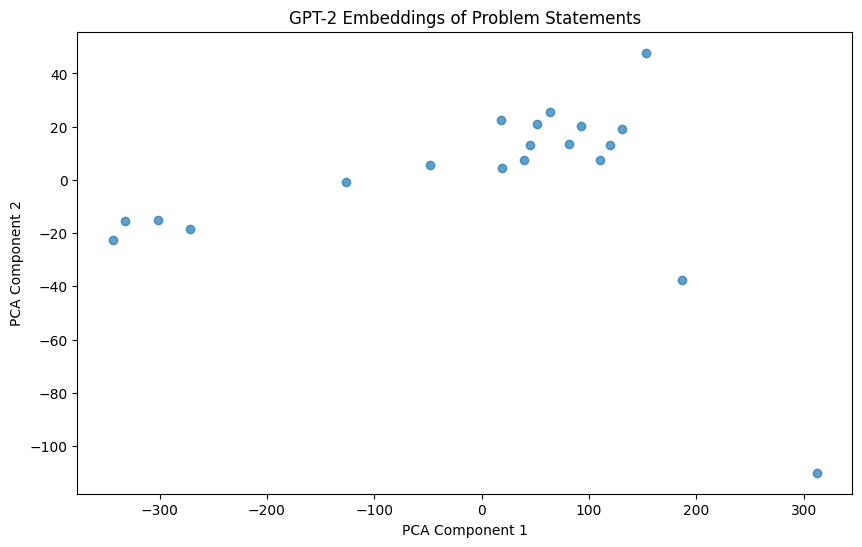

In [14]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

model_name = 'gpt2'

tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token
model_ = GPT2Model.from_pretrained(model_name, output_hidden_states=True).to(device).eval()

def get_gpt2_embeddings(prompts):
    embeddings = []
    for prompt in prompts:
        input_ids = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=50)["input_ids"].to(device)

        with torch.no_grad():
            outputs = model_(input_ids, output_hidden_states=True)
        
        last_hidden_state = outputs.hidden_states[-1]  # Get the last layer's hidden state
        pooled_embedding = last_hidden_state[:, -1, :].cpu().numpy()  # Take last token embedding

        embeddings.append(pooled_embedding.squeeze())

    return np.array(embeddings)

embeddings = get_gpt2_embeddings(prompts)

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GPT-2 Embeddings of Problem Statements")
plt.show()


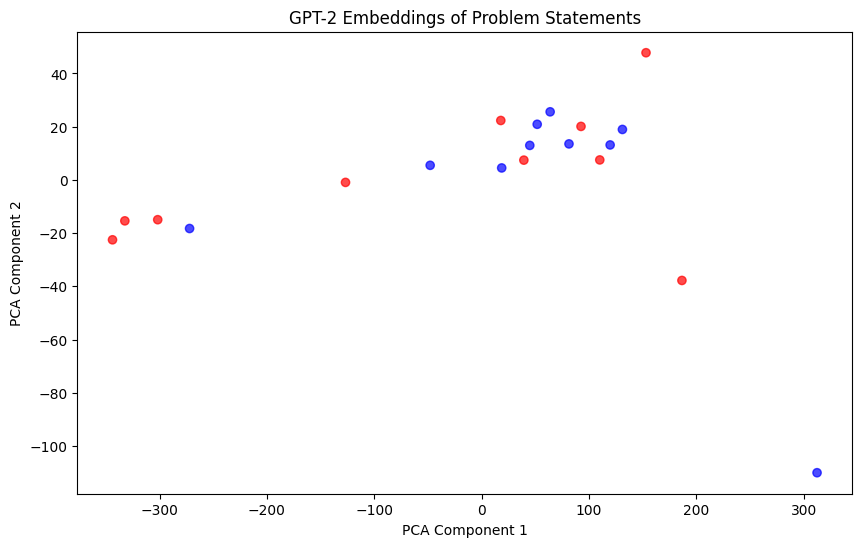

In [15]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Define colors: first 10 red, last 10 blue
colors = ['red'] * 10 + ['blue'] * (len(embeddings_2d) - 10)

plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GPT-2 Embeddings of Problem Statements")
plt.show()
